In [ ]:
# for google colab
from google.colab import drive
# mount your Google Drive
drive.mount('/content/gdrive')

In [ ]:
%cd /content/gdrive/Shareddrives/'AI Final Project'/code

/content/gdrive/Shareddrives/AI Final Project/code


In [ ]:
data_path = '/content/gdrive/Shareddrives/AI Final Project/dataset'

In [ ]:
#For Images
import cv2
import matplotlib.pyplot as plt
import numpy as np

#For checking progress
from tqdm import tqdm_notebook

# This is for the progress bar.
from tqdm.auto import tqdm

import datetime

#PyTorch Packages
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from PIL import Image

# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

import time

## **Dataset, Data Loader, and Transforms**

In [ ]:
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [ ]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 128

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder(data_path + "/train", loader=lambda x: Image.open(x).convert("RGB"), extensions="png", transform=train_tfm)
test_set = DatasetFolder(data_path + "/test", loader=lambda x: Image.open(x).convert("RGB"), extensions="png", transform=test_tfm)
testGoogle_set = DatasetFolder(data_path + "/testGoogle", loader=lambda x: Image.open(x).convert("RGB"), extensions="png", transform=test_tfm)

# split train set into train and valid set
# valid_set = DatasetFolder(data_path + "/train", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# 法1
# validation_split = .2
# shuffle_dataset = True
# random_seed= 42

# # Creating data indices for training and validation splits:
# dataset_size = len(train_set)
# indices = list(range(dataset_size))
# split = int(np.floor(validation_split * dataset_size))
# if shuffle_dataset :
#     np.random.seed(random_seed)
#     np.random.shuffle(indices)
# train_indices, val_indices = indices[split:], indices[:split]

# # Creating PT data samplers and loaders:
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)

# 法2
train_size = int(0.8 * len(train_set))
valid_size = len(train_set) - train_size
train_set, valid_set = torch.utils.data.random_split(train_set, [train_size, valid_size])

# Construct data loaders.
# train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=2, pin_memory=True, sampler=train_sampler)
# valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=2, pin_memory=True, sampler=valid_sampler)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
testGoogle_loader = DataLoader(testGoogle_set, batch_size=batch_size, shuffle=False)

# src: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets/50544887#50544887

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## **Model**


In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 64, 64]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),#output 64*64*64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),#output 64*32*32

            nn.Conv2d(64, 128, 3, 1, 1),#output 128*32*32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),#output 128*16*16

            nn.Conv2d(128, 256, 3, 1, 1),#output 256*16*16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),#output 256*4*4
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 6)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

## **Training**

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

t1 = time.time()

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 50

training_loss_epochs = []
validation_loss_epochs = []
training_accuracy_epochs = []
validation_accuracy_epochs = []

for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    
    training_loss_epochs.append(train_loss)
    training_accuracy_epochs.append(train_acc)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    validation_loss_epochs.append(valid_loss)
    validation_accuracy_epochs.append(valid_acc)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

t2 = time.time()
print('time elapsed: ' + str(t2-t1) + ' seconds')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



[ Train | 001/050 ] loss = 0.65031, acc = 0.76212



[ Valid | 001/050 ] loss = 0.34615, acc = 0.88255



[ Train | 002/050 ] loss = 0.22345, acc = 0.92210



[ Valid | 002/050 ] loss = 0.23239, acc = 0.91293



[ Train | 003/050 ] loss = 0.15336, acc = 0.94735



[ Valid | 003/050 ] loss = 0.16528, acc = 0.93377



[ Train | 004/050 ] loss = 0.10220, acc = 0.96445



[ Valid | 004/050 ] loss = 0.09883, acc = 0.96571



[ Train | 005/050 ] loss = 0.07526, acc = 0.97396



[ Valid | 005/050 ] loss = 0.09188, acc = 0.96962



[ Train | 006/050 ] loss = 0.08167, acc = 0.97339



[ Valid | 006/050 ] loss = 0.08113, acc = 0.97309



[ Train | 007/050 ] loss = 0.05910, acc = 0.98087



[ Valid | 007/050 ] loss = 0.04383, acc = 0.98481



[ Train | 008/050 ] loss = 0.05525, acc = 0.98120



[ Valid | 008/050 ] loss = 0.11322, acc = 0.95964



[ Train | 009/050 ] loss = 0.04835, acc = 0.98415



[ Valid | 009/050 ] loss = 0.12005, acc = 0.96007



[ Train | 010/050 ] loss = 0.04553, acc = 0.98460



[ Valid | 010/050 ] loss = 0.05294, acc = 0.97917



[ Train | 011/050 ] loss = 0.04773, acc = 0.98370



[ Valid | 011/050 ] loss = 0.03050, acc = 0.99132



[ Train | 012/050 ] loss = 0.01963, acc = 0.99355



[ Valid | 012/050 ] loss = 0.05150, acc = 0.97630



[ Train | 013/050 ] loss = 0.02091, acc = 0.99264



[ Valid | 013/050 ] loss = 0.07797, acc = 0.97179



[ Train | 014/050 ] loss = 0.03413, acc = 0.98822



[ Valid | 014/050 ] loss = 0.14858, acc = 0.95877



[ Train | 015/050 ] loss = 0.03052, acc = 0.98890



[ Valid | 015/050 ] loss = 0.19752, acc = 0.93620



[ Train | 017/050 ] loss = 0.01549, acc = 0.99536



[ Valid | 017/050 ] loss = 0.03277, acc = 0.98915



[ Train | 018/050 ] loss = 0.00997, acc = 0.99649



[ Valid | 018/050 ] loss = 0.06894, acc = 0.98047



[ Train | 019/050 ] loss = 0.04826, acc = 0.98426



[ Valid | 019/050 ] loss = 0.07179, acc = 0.96832



[ Train | 020/050 ] loss = 0.01020, acc = 0.99796



[ Valid | 020/050 ] loss = 0.02362, acc = 0.99262



[ Train | 021/050 ] loss = 0.00980, acc = 0.99672



[ Valid | 021/050 ] loss = 0.02065, acc = 0.99392



[ Train | 022/050 ] loss = 0.00189, acc = 0.99977



[ Valid | 022/050 ] loss = 0.02008, acc = 0.99392



[ Train | 023/050 ] loss = 0.00200, acc = 0.99898



[ Valid | 023/050 ] loss = 0.02006, acc = 0.99392



[ Train | 024/050 ] loss = 0.04775, acc = 0.98381



[ Valid | 024/050 ] loss = 0.04207, acc = 0.98524



[ Train | 025/050 ] loss = 0.00927, acc = 0.99808



[ Valid | 025/050 ] loss = 0.01676, acc = 0.99523



[ Train | 026/050 ] loss = 0.00141, acc = 0.99989



[ Valid | 026/050 ] loss = 0.01870, acc = 0.99479



[ Train | 027/050 ] loss = 0.00092, acc = 1.00000



[ Valid | 027/050 ] loss = 0.01876, acc = 0.99479



[ Train | 028/050 ] loss = 0.00591, acc = 0.99909



[ Valid | 028/050 ] loss = 0.03854, acc = 0.98958



[ Train | 029/050 ] loss = 0.03247, acc = 0.98902



[ Valid | 029/050 ] loss = 0.02548, acc = 0.99262



[ Train | 030/050 ] loss = 0.02282, acc = 0.99185



[ Valid | 030/050 ] loss = 0.11227, acc = 0.96354



[ Train | 031/050 ] loss = 0.00667, acc = 0.99841



[ Valid | 031/050 ] loss = 0.05106, acc = 0.98611



[ Train | 032/050 ] loss = 0.04524, acc = 0.98834



[ Valid | 032/050 ] loss = 0.04600, acc = 0.98611



[ Train | 033/050 ] loss = 0.02456, acc = 0.99139



[ Valid | 033/050 ] loss = 0.01986, acc = 0.99479



[ Train | 034/050 ] loss = 0.00310, acc = 0.99921



[ Valid | 034/050 ] loss = 0.02307, acc = 0.99436



[ Train | 035/050 ] loss = 0.00303, acc = 0.99909



[ Valid | 035/050 ] loss = 0.03214, acc = 0.99045



[ Train | 036/050 ] loss = 0.01737, acc = 0.99615



[ Valid | 036/050 ] loss = 0.02209, acc = 0.99436



[ Train | 037/050 ] loss = 0.02025, acc = 0.99355



[ Valid | 037/050 ] loss = 0.04061, acc = 0.98828



[ Train | 038/050 ] loss = 0.00545, acc = 0.99841



[ Valid | 038/050 ] loss = 0.01948, acc = 0.99436



[ Train | 039/050 ] loss = 0.00109, acc = 0.99989



[ Valid | 039/050 ] loss = 0.01840, acc = 0.99653



[ Train | 040/050 ] loss = 0.00636, acc = 0.99774



[ Valid | 040/050 ] loss = 0.02078, acc = 0.99566



[ Train | 041/050 ] loss = 0.00807, acc = 0.99728



[ Valid | 041/050 ] loss = 0.02793, acc = 0.99349



[ Train | 042/050 ] loss = 0.00483, acc = 0.99864



[ Valid | 042/050 ] loss = 0.02301, acc = 0.99306



[ Train | 043/050 ] loss = 0.00161, acc = 0.99977



[ Valid | 043/050 ] loss = 0.01673, acc = 0.99566



[ Train | 044/050 ] loss = 0.00586, acc = 0.99819



[ Valid | 044/050 ] loss = 0.02494, acc = 0.99349



[ Train | 045/050 ] loss = 0.00126, acc = 0.99966



[ Valid | 045/050 ] loss = 0.01963, acc = 0.99436



[ Train | 046/050 ] loss = 0.00060, acc = 0.99989



[ Valid | 046/050 ] loss = 0.01651, acc = 0.99609



[ Train | 047/050 ] loss = 0.00026, acc = 1.00000



[ Valid | 047/050 ] loss = 0.01590, acc = 0.99566



[ Train | 048/050 ] loss = 0.00379, acc = 0.99875



[ Valid | 048/050 ] loss = 0.03330, acc = 0.99306



[ Train | 049/050 ] loss = 0.00269, acc = 0.99875



[ Valid | 049/050 ] loss = 0.02479, acc = 0.99349



[ Train | 050/050 ] loss = 0.02206, acc = 0.99343



[ Valid | 050/050 ] loss = 0.19906, acc = 0.94939
time elapsed: 3127.182713508606 seconds


In [ ]:
# save the trained weight
torch.save(model.state_dict(), 'FreshnessDetector-64_64_3.pt')

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Classifier().to(device)
model.load_state_dict(torch.load('FreshnessDetector-64_64_3_v3.pt'))
model.eval()

Classifier(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, b

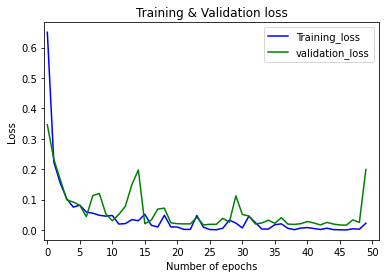

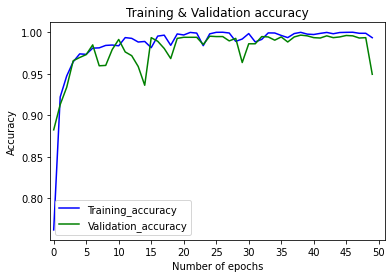

In [ ]:
from matplotlib.pyplot import MultipleLocator
# visualization
plt.plot(range(n_epochs), training_loss_epochs, 'b-', label='Training_loss')
plt.plot(range(n_epochs), validation_loss_epochs, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.xticks(range(n_epochs))

x_major_locator=MultipleLocator(5)#把x轴的刻度间隔设置为1，并存在变量里
ax=plt.gca()#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)#把x轴的主刻度设置为1的倍数
plt.xlim(-0.5,n_epochs+1)#把x轴的刻度范围设置为-0.5到11，因为0.5不满一个刻度间隔，所以数字不会显示出来，但是能看到一点空白

plt.legend()
plt.show()


plt.plot(range(n_epochs), training_accuracy_epochs, 'b-', label='Training_accuracy')
plt.plot(range(n_epochs), validation_accuracy_epochs, 'g-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.xticks(range(n_epochs))

x_major_locator=MultipleLocator(5)#把x轴的刻度间隔设置为1，并存在变量里
ax=plt.gca()#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)#把x轴的主刻度设置为1的倍数
plt.xlim(-0.5,n_epochs+1)#把x轴的刻度范围设置为-0.5到11，因为0.5不满一个刻度间隔，所以数字不会显示出来，但是能看到一点空白

'''
————————————————
版权声明：本文为CSDN博主「宁宁Fingerstyle」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/weixin_44520259/article/details/89917026
'''
plt.legend()
plt.show()

# Test our model

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Actual: 2
Prediction: tensor([[ -5.6398,  -8.1836,  10.7309,   5.9605, -15.4207,   0.8629]],
       device='cuda:0', grad_fn=<AddmmBackward>)


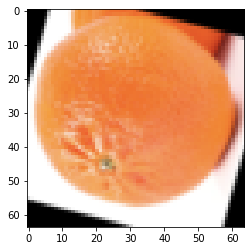

In [ ]:
img,label = test_set[1000]
plt.imshow(img.permute(1,2,0))
out = model(img.unsqueeze(0).to(device))
print('Actual: {}'.format(label))
print('Prediction: {}'.format(out))

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
Categories=['freshapples','freshbanana','freshoranges','rottenapples','rottenbanana','rottenoranges']

#####overall result

In [ ]:
# ---------- Test ----------
# Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
model.eval()

y_test = []
y_test_predict = []

for img,label in test_set:
  out = model(img.unsqueeze(0).to(device))
  predict_value = int(out.argmax(dim=-1))

  # Record the loss and accuracy.
  y_test.append(label)
  y_test_predict.append(predict_value)

print("Test data")

print(f"The model is {accuracy_score(y_test, y_test_predict)*100}% accurate")
print("report:\n",classification_report(y_test, y_test_predict, target_names=Categories, digits=4))
print("confusion matrix:\n",confusion_matrix(y_test, y_test_predict))


Test data
The model is 96.10822831727205% accurate
report:
                precision    recall  f1-score   support

  freshapples     1.0000    0.9519    0.9754       395
  freshbanana     0.9948    0.9974    0.9961       381
 freshoranges     0.9898    0.9974    0.9936       388
 rottenapples     0.8584    0.9983    0.9231       601
 rottenbanana     1.0000    0.9283    0.9628       530
rottenoranges     1.0000    0.8883    0.9409       403

     accuracy                         0.9611      2698
    macro avg     0.9738    0.9603    0.9653      2698
 weighted avg     0.9662    0.9611    0.9616      2698

confusion matrix:
 [[376   1   1  17   0   0]
 [  0 380   0   1   0   0]
 [  0   0 387   1   0   0]
 [  0   0   1 600   0   0]
 [  0   1   0  37 492   0]
 [  0   0   2  43   0 358]]


In [ ]:
### 再測一次train的準確度，總感覺前面訓練過程中他是先抓資料再更新model
# ---------- Train ----------
# Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
model.eval()

y_train = []
y_train_predict = []

for img,label in train_set:
  out = model(img.unsqueeze(0).to(device))
  predict_value = int(out.argmax(dim=-1))

  # Record the loss and accuracy.
  y_train.append(label)
  y_train_predict.append(predict_value)

print("Train data")

print(f"The model is {accuracy_score(y_train, y_train_predict)*100}% accurate")
print("report:\n",classification_report(y_train, y_train_predict, target_names=Categories, digits=4))
print("confusion matrix:\n",confusion_matrix(y_train, y_train_predict))


Train data
The model is 97.46559633027523% accurate
report:
                precision    recall  f1-score   support

  freshapples     1.0000    0.9807    0.9903      1348
  freshbanana     0.9968    1.0000    0.9984      1265
 freshoranges     0.9949    1.0000    0.9974      1169
 rottenapples     0.8992    0.9984    0.9462      1886
 rottenbanana     1.0000    0.9531    0.9760      1771
rottenoranges     1.0000    0.9149    0.9556      1281

     accuracy                         0.9747      8720
    macro avg     0.9818    0.9745    0.9773      8720
 weighted avg     0.9771    0.9747    0.9749      8720

confusion matrix:
 [[1322    0    0   26    0    0]
 [   0 1265    0    0    0    0]
 [   0    0 1169    0    0    0]
 [   0    0    3 1883    0    0]
 [   0    4    0   79 1688    0]
 [   0    0    3  106    0 1172]]


In [ ]:
# ---------- Test Google ----------
# Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
model.eval()

y_testGoogle = []
y_testGoogle_predict = []

for img,label in testGoogle_set:
  out = model(img.unsqueeze(0).to(device))
  predict_value = int(out.argmax(dim=-1))

  # Record the loss and accuracy.
  y_testGoogle.append(label)
  y_testGoogle_predict.append(predict_value)

print("Test Google data")

print(f"The model is {accuracy_score(y_testGoogle, y_testGoogle_predict)*100}% accurate")
print("report:\n",classification_report(y_testGoogle, y_testGoogle_predict, target_names=Categories, digits=4))
print("confusion matrix:\n",confusion_matrix(y_testGoogle, y_testGoogle_predict))


Test Google data
The model is 85.48387096774194% accurate
report:
                precision    recall  f1-score   support

  freshapples     1.0000    0.7273    0.8421        11
  freshbanana     0.9286    0.8667    0.8966        15
 freshoranges     0.8889    0.8889    0.8889         9
 rottenapples     0.6250    0.7143    0.6667         7
 rottenbanana     0.8333    1.0000    0.9091        10
rottenoranges     0.8182    0.9000    0.8571        10

     accuracy                         0.8548        62
    macro avg     0.8490    0.8495    0.8434        62
 weighted avg     0.8680    0.8548    0.8555        62

confusion matrix:
 [[ 8  0  0  3  0  0]
 [ 0 13  0  0  1  1]
 [ 0  0  8  0  0  1]
 [ 0  1  0  5  1  0]
 [ 0  0  0  0 10  0]
 [ 0  0  1  0  0  9]]


#####check the wrongly predicted img (in test set)


In [ ]:
diff_idx = []

truth = y_testGoogle
predicted = y_testGoogle_predict

for i in range(len(truth)):
  if truth[i] != predicted[i]:
    diff_idx.append(i)
    # first_diff_idx = i
    # break

print(len(diff_idx))

Actual: 0
Prediction: tensor([[ 5.1963, -4.3327, -4.4005,  5.7218,  0.8252, -5.4761]],
       device='cuda:0', grad_fn=<AddmmBackward>)
Actual: 0
Prediction: tensor([[ 6.5216e-03, -5.6723e+00, -2.7116e+00,  6.7267e+00,  2.4903e+00,
         -1.9817e+00]], device='cuda:0', grad_fn=<AddmmBackward>)
Actual: 0
Prediction: tensor([[  3.6262,   3.3291,  -6.4075,   4.8143,   4.3398, -13.7616]],
       device='cuda:0', grad_fn=<AddmmBackward>)
Actual: 1
Prediction: tensor([[ -9.5483,   0.9548, -12.0914,  -9.2488,  -1.0836,  14.9709]],
       device='cuda:0', grad_fn=<AddmmBackward>)
Actual: 1
Prediction: tensor([[-23.6222,   5.6954,   6.7946,  -5.8096,  10.4715,   0.6019]],
       device='cuda:0', grad_fn=<AddmmBackward>)
Actual: 2
Prediction: tensor([[-13.4634,  -1.5082,   9.6249, -15.6473,  -7.3164,  12.5432]],
       device='cuda:0', grad_fn=<AddmmBackward>)
Actual: 3
Prediction: tensor([[-17.7315,  -1.1014, -11.0031,   9.0969,  17.2697,  -1.5451]],
       device='cuda:0', grad_fn=<AddmmBac

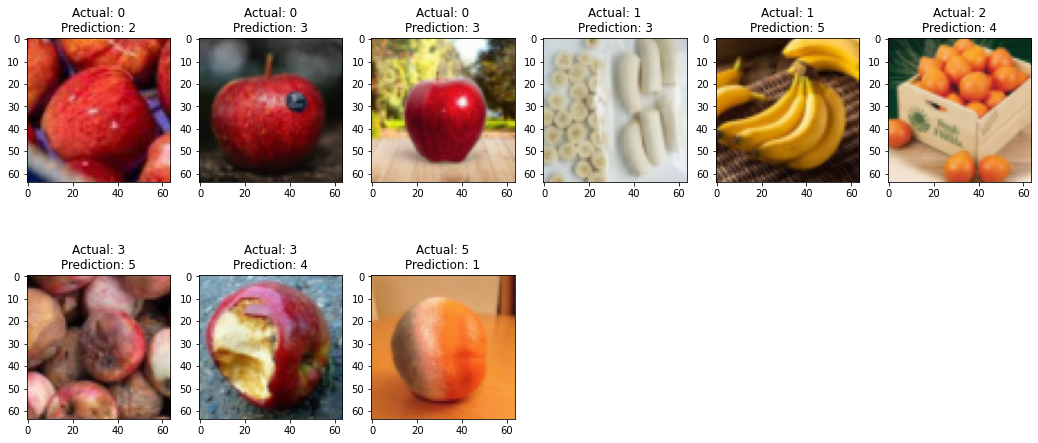

In [ ]:
fig = plt.figure(figsize=(18, 8))
columns = 6
rows = 2

# ax enables access to manipulate each of subplots
ax = []

print('Wrong Prediction:')
for i in range(len(diff_idx)):
  img,label = testGoogle_set[diff_idx[i]]
  # create subplot and append to ax
  ax.append( fig.add_subplot(rows, columns, i+1) )
  ax[-1].set_title('Actual: {}\nPrediction: {}'.format(label, torch.argmax(out)))  # set title
  plt.imshow(img.permute(1,2,0))
  out = model(img.unsqueeze(0).to(device))
  print('Actual: {}'.format(label))
  print('Prediction: {}'.format(out))

plt.show()

# Test Using Google Data

In [ ]:
# for google colab
# REMEMBER to execute this line once you've modified any .py code!
# Save the .py code you have modified to your Google Drive
!cp ./*.py ./gdrive/Shareddrives/'AI Final Project'/code/